##A supervised multiclassification problem: the iris dataset.

The aim is to build a machine learning model for classifying the specie of iris flowers according to some features (e.g. petal length and petal width).

It is a supervised multiclassifcation problem since we already know the features and the correspondent output and the number of classes (=species), that is higher than 2.

The fist step is to import the dataset (from a local directory), convert it into a pandas dataframe and to explore it. 

In [1]:
#import all libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
from numpy import set_printoptions
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score   
from sklearn.model_selection import ShuffleSplit     
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict    
from sklearn.tree import DecisionTreeClassifier                              
from sklearn.neighbors import KNeighborsClassifier                          
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis        
from sklearn.naive_bayes import GaussianNB                                  
from sklearn.svm import SVC   
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import classification_report    
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.pipeline import Pipeline           

In [2]:
from google.colab import files
uploaded = files.upload()

Saving iris_dataset.csv to iris_dataset.csv


In [3]:
filename = 'iris_dataset.csv'
data = pd.read_csv(filename)

In [4]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


After looking at the raw data, it is important to anderstand the dataset. It is possible to check if null features are present and to extract some informations such as dimension, data size, descriptive statistics and the distribution of the instances across classes.  

In [5]:
print(data.isnull().sum(),'\n')
print(data.isna().sum(),'\n')
print('Shape:',data.shape,'\n')
print(data.dtypes,'\n')
print(data.groupby('species').size(),'\n')
data.describe().style.background_gradient()


sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64 

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64 

Shape: (150, 5) 

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object 

species
setosa        50
versicolor    50
virginica     50
dtype: int64 



,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


This dataset containes 150 iris flowers. For each flower we have 4 features and the correspondent specie (class). 
Now it is possible to better explore and visualize the data using seaborn and matplotlib, for both univariate and multivariate plots. 

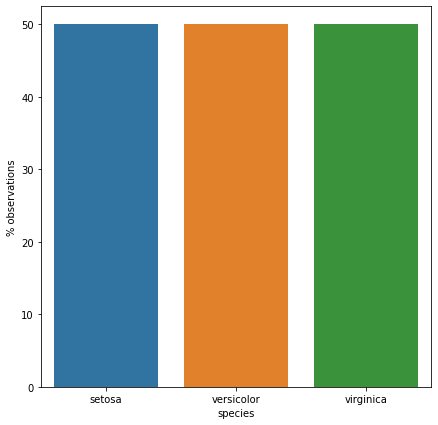

In [6]:
#Simple plot for showing the % of the different classes
plt.figure(figsize=(7,7))
target_var=pd.crosstab(index=data['species'],columns='% observations')
sbn.barplot(x=target_var.index,y=target_var['% observations'])
plt.show()

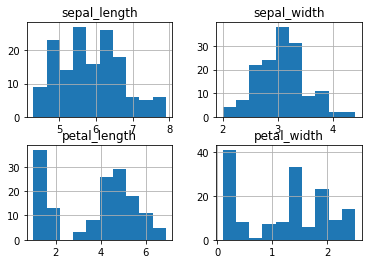

In [7]:
#Plot of the attributes for understaning if it is needed to fix the data 
data.hist()
plt.rcParams["figure.figsize"] = [10,10] 
plt.show()

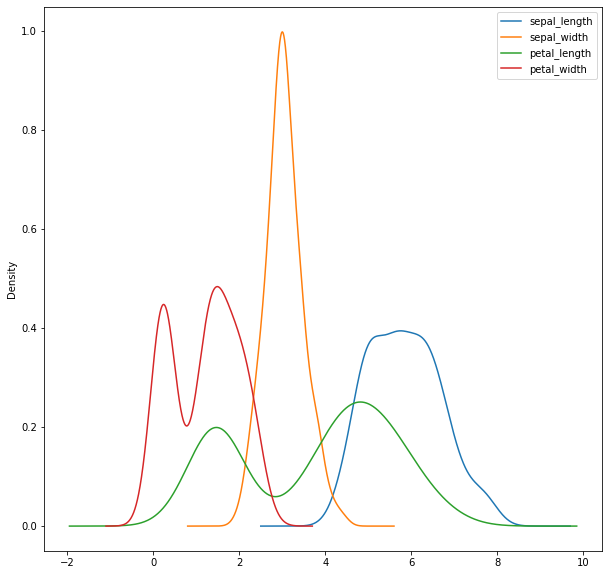

In [8]:
#Plot of the overall behaviour of the features 
data.plot(kind='density', subplots=False, layout=(3,3), sharex=False)
plt.show()

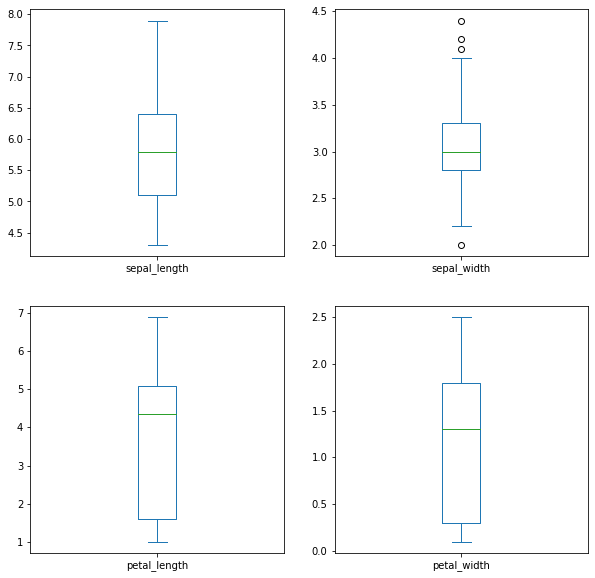

In [9]:
#Boxplot for showing simmetry of data according to the mean in the interquartile box. The outliers are the dots. The identification of the outliers
#is important since they may led to wrong associations.
data.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

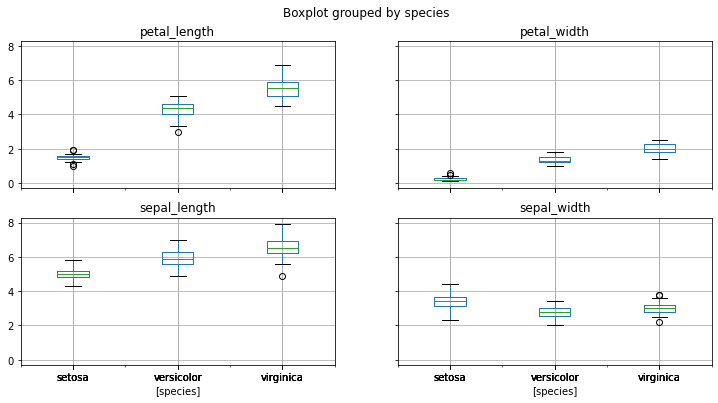

In [10]:
#Also it is possible to generate boxplots in which flowers are grouped by species.
data.boxplot(by="species", figsize=(12, 6))
plt.show() 

In [11]:
#As it is possible to see from the plots, there are some outliers that we can drop
#in order to not bias the analysis.
species=['setosa','versicolor','virginica']
features=[]
for y in data.columns:
  if y != 'species':
    features.append(y)

for specie in species: #for each specie we drop the outliers 
  spec_data=data[(data['species']==specie)]
  for feature in features:
    q1=spec_data[feature].quantile(0.25)
    q3=spec_data[feature].quantile(0.75)
    iqr=q3-q1

    to_delete=spec_data[(spec_data[feature] < q1-(1.5*iqr)) | (spec_data[feature] > q3+(1.5*iqr))][feature]
    if len(to_delete)!=0:
      data=data.drop([to_delete.index[0]])

print('The new dataset contains',data.shape[0],'flowers')

The new dataset contains 145 flowers


##Focus on feature selection.
Selecting the right features for solving a machine learning problem is important for using only relevant features, for getting rid of noisy data and for avoiding the so-called overfitting problem. Using some correalation startegies, it is possible to understand the relationships among the different parameters of the dataset. 

- It is possible to determine the pairwise correlation (strength of relationship between pairs of features) using the PEARSON CORRELATION. The coefficient is a value between -1 and 1, with 1 that indicates strong correlation. 

- The use of the HEATAP allow to visualize these relationships, again positive values show high correlation. 

- Another way for plotting all the pairwise relationships is the so-called PAIRPLOT. This type of plot is quite powerful since it shows also the distribution of each single variable. 

In [12]:
#PEARSON CORRELATION 
data.corr(method='pearson')

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.160649,0.874946,0.824844
sepal_width,-0.160649,1.000000,-0.457154,-0.379742
petal_length,0.874946,-0.457154,1.000000,0.962425
petal_width,0.824844,-0.379742,0.962425,1.000000


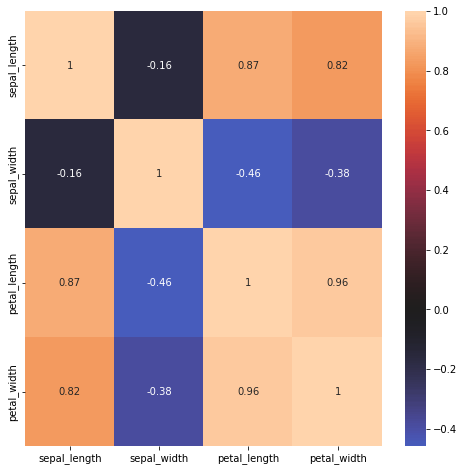

In [13]:
#HEATMAP
plt.figure(figsize=(8,8))
sbn.heatmap(data.select_dtypes(include=['float']).corr(),annot=True,center = 0)
plt.show()

e.g. from the matrix above it is possible to understand that petal_length and petal_width are strongly correlated. 
Anyway, in this machine learning problem would be useless to reduce the number of features since their number is already small and it is not needed to reduce them in order to make the training faster. 

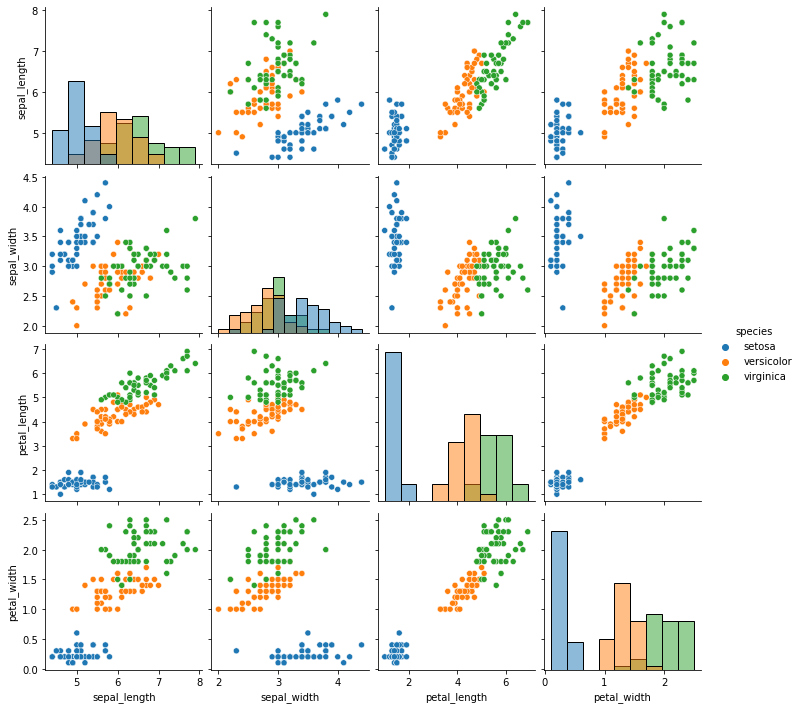

In [14]:
#PAIRPLOT
sbn.pairplot(data, hue="species" , diag_kind="hist")

##Prepare the dataset to train the model 
Before training a machine learning model we may need to rescale, standardize, normalize or binarize the data. This depends on the type of data we have and on the type of problem we need to solve and it is important to make gradient descend easier and faster. 

In this case the idea is to apply the different types of feature scaling (rescaling, standardization, normalization) on the dataset for testing different types of machine learning algorithms. Then the classification performance will be measured for choosing the best model.  


###RESCALING 

In [15]:
array = data.values

#Now separe input and output for scaling only input data
X = array[:,0:4] #input 
Y = array[:,4] #output

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)
set_printoptions(precision=3)
print('Data not scaled\n', X[0:10,:])
print()
print('Scaled data\n', rescaledX[0:10,:]) 

Data not scaled
 [[5.1 3.5 1.4 0.2]
 [4.9 3.0 1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.0 3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.0 3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]

Scaled data
 [[0.2   0.625 0.068 0.042]
 [0.143 0.417 0.068 0.042]
 [0.086 0.5   0.051 0.042]
 [0.057 0.458 0.085 0.042]
 [0.171 0.667 0.068 0.042]
 [0.286 0.792 0.119 0.125]
 [0.057 0.583 0.068 0.083]
 [0.171 0.583 0.085 0.042]
 [0.    0.375 0.068 0.042]
 [0.143 0.458 0.085 0.   ]]


Now we can plot the scaled dataset again and check how the distribution has changed. 

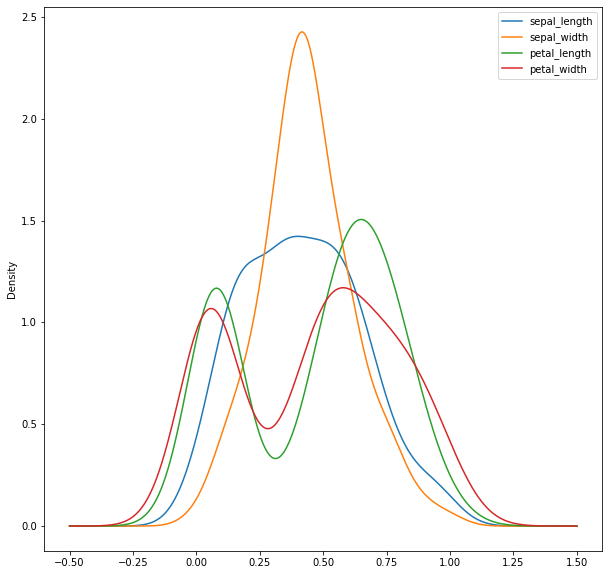

In [17]:
scaled_data=pd.DataFrame(rescaledX, columns=['sepal_length' , 'sepal_width' , 'petal_length' , 'petal_width' ])
#scaled_data

scaled_data.plot(kind='density', subplots=False, layout=(3,3), sharex=False)
plt.show()


###STANDARDIZING 

In [18]:
scaler = StandardScaler().fit(X)
standardizedX = scaler.transform(X)
set_printoptions(precision=3)
print('Standardized data\n',standardizedX[0:10,:])

Standardized data
 [[-0.94   1.035 -1.357 -1.317]
 [-1.188 -0.128 -1.357 -1.317]
 [-1.436  0.337 -1.414 -1.317]
 [-1.56   0.104 -1.3   -1.317]
 [-1.064  1.268 -1.357 -1.317]
 [-0.568  1.966 -1.185 -1.054]
 [-1.56   0.802 -1.357 -1.186]
 [-1.064  0.802 -1.3   -1.317]
 [-1.808 -0.361 -1.357 -1.317]
 [-1.188  0.104 -1.3   -1.449]]


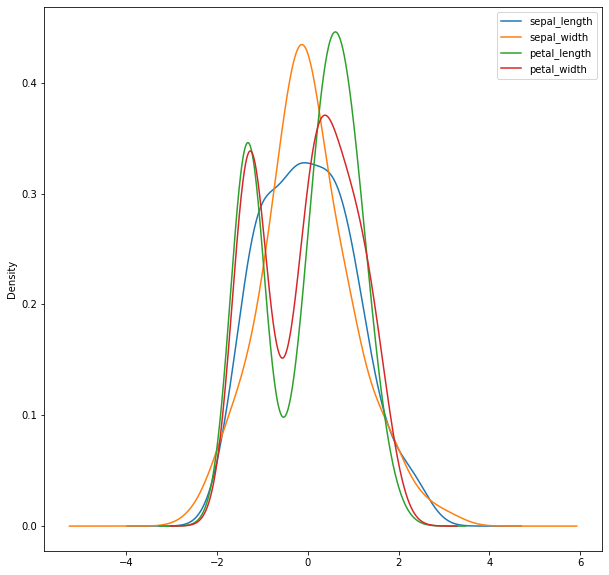

In [19]:
standardized_data=pd.DataFrame(standardizedX, columns=['sepal_length' , 'sepal_width' , 'petal_length' , 'petal_width' ])
standardized_data.plot(kind='density', subplots=False, layout=(3,3), sharex=False)
plt.show()

###Normalization 


In [20]:
scaler = Normalizer().fit(X)
normalizedX = scaler.transform(X)
set_printoptions(precision=3)
print('Normalized data\n',normalizedX[0:10,:])

Normalized data
 [[0.804 0.552 0.221 0.032]
 [0.828 0.507 0.237 0.034]
 [0.805 0.548 0.223 0.034]
 [0.8   0.539 0.261 0.035]
 [0.791 0.569 0.221 0.032]
 [0.784 0.566 0.247 0.058]
 [0.78  0.577 0.237 0.051]
 [0.802 0.545 0.241 0.032]
 [0.806 0.532 0.257 0.037]
 [0.818 0.518 0.25  0.017]]


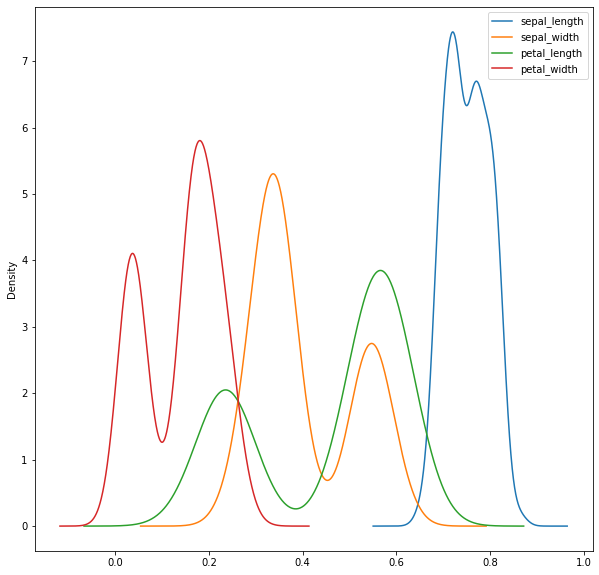

In [21]:
normalized_data=pd.DataFrame(normalizedX, columns=['sepal_length' , 'sepal_width' , 'petal_length' , 'petal_width' ])
normalized_data.plot(kind='density', subplots=False, layout=(3,3), sharex=False)
plt.show()

#Before the evaluation of the performance of ML algorithms 

In order to train a machine learning model so that it is able to make prediction about unseen dataset and in order to evaluate its performance we need to split the dataset. This is importante because the prediction should not be performed on the same data used for the training. 



##Splitting of the dataset into training and testing set. 
This procedures is useful with large dataset but it may be needed to check for class imbalance such that the training occurs with a set in which the number of flowers in the different classes is similar. 

In [22]:
test_size = 0.33
seed = 7          
X_train, X_test, Y_train, Y_test= train_test_split(X, Y,test_size=test_size,random_state=7)
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, Y_train) 
result = model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (result*100.0))

Accuracy: 93.750%


##Validation with resampling
Resampling procedures allow to understand if the model is suffering of bias or variance, in particular when dealing with small dataset. 
The methods used below are:


*   K-fold Cross-Validation
*   Leave One Out Cross-Validation
*   Repeated Random Test-Train Splits

K-fold Cross-Validation will be used as resampling technique due to the final result (96.667% (st= 5.375%))





In [23]:
test_size = 0.33
seed = 7
validation_m=[]
validation_m.append(('K-fold Cross-Validation',KFold(n_splits=10, random_state=seed, shuffle=True)))
validation_m.append(('Leave One Out Cross-Validation',LeaveOneOut()))
validation_m.append(('Repeated Random Test-Train Splits',ShuffleSplit(n_splits=10, test_size=test_size, random_state=seed)))

for method in  validation_m:
  type_m=method[1]
  model=LogisticRegression(solver='lbfgs', max_iter=1000)
  results = cross_val_score(model, X, Y, cv=type_m)
  print("Accuracy with method %s: %.3f%% (st= %.3f%%)" % (method[0],results.mean()*100.0, results.std()*100.0))


Accuracy with method K-fold Cross-Validation: 96.524% (st= 4.724%)
Accuracy with method Leave One Out Cross-Validation: 96.552% (st= 18.247%)
Accuracy with method Repeated Random Test-Train Splits: 96.042% (st= 2.543%)


#Evaluation of the performance of different classification algorithms
We will now use different classification metrics in order to evaluate the performance of different types of algorithms using the K-fold Cross-Validation method on the different types of dataset (not processed, rescaled, standardized, normalized).
The metrics are:
- Classification Accuracy
- Logarithmic Loss
- Area Under ROC Curve
- Confusion Matrix
- Classification Report


Classification on  NOT PROCESSED data:

Model:  LR
accuracy : 0.965 (0.047)
neg_log_loss : -0.130 (0.052)

Model:  LDA
accuracy : 0.979 (0.032)
neg_log_loss : -0.050 (0.061)

Model:  KNN
accuracy : 0.980 (0.031)
neg_log_loss : -0.285 (0.691)

Model:  CART
accuracy : 0.959 (0.055)
neg_log_loss : -1.431 (1.910)

Model:  NB
accuracy : 0.965 (0.048)
neg_log_loss : -0.105 (0.129)

Model:  SVM
accuracy : 0.973 (0.045)
neg_log_loss : -0.095 (0.054)



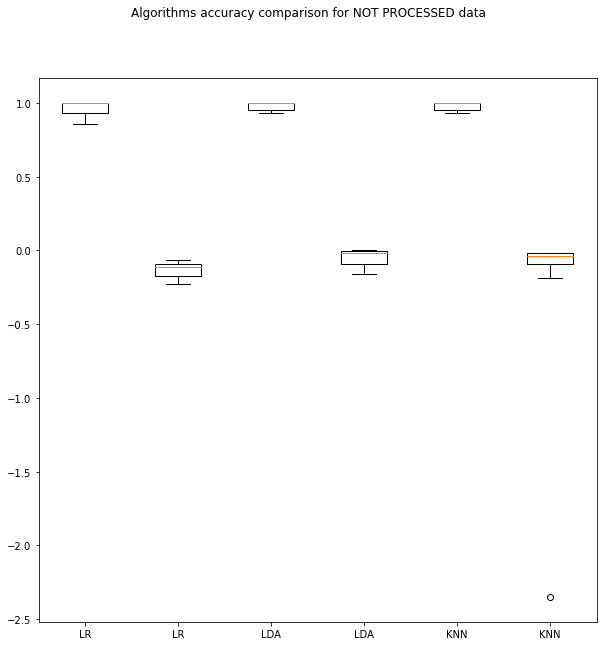


Classification on  RESCALED data:

Model:  LR
accuracy : 0.923 (0.058)
neg_log_loss : -0.373 (0.050)

Model:  LDA
accuracy : 0.979 (0.032)
neg_log_loss : -0.050 (0.061)

Model:  KNN
accuracy : 0.958 (0.056)
neg_log_loss : -0.085 (0.063)

Model:  CART
accuracy : 0.959 (0.055)
neg_log_loss : -1.431 (1.910)

Model:  NB
accuracy : 0.965 (0.048)
neg_log_loss : -0.105 (0.129)

Model:  SVM
accuracy : 0.965 (0.056)
neg_log_loss : -0.099 (0.051)



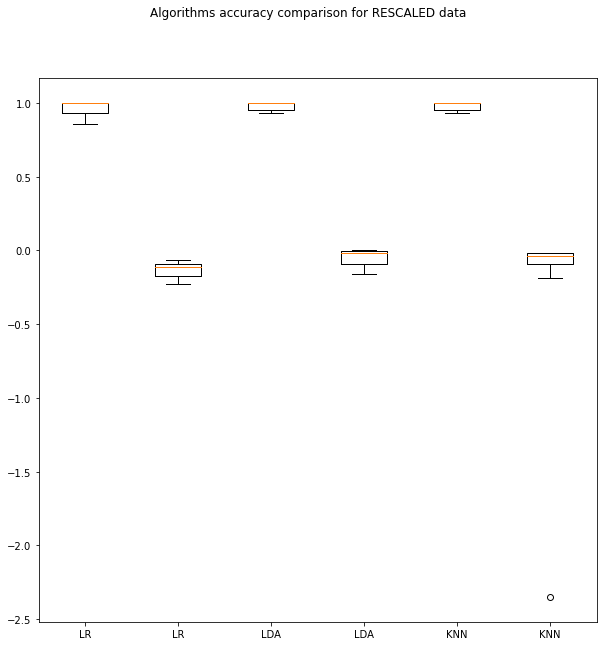


Classification on  STANDARDIZED data:

Model:  LR
accuracy : 0.958 (0.056)
neg_log_loss : -0.146 (0.048)

Model:  LDA
accuracy : 0.979 (0.032)
neg_log_loss : -0.050 (0.061)

Model:  KNN
accuracy : 0.959 (0.045)
neg_log_loss : -0.313 (0.726)

Model:  CART
accuracy : 0.966 (0.056)
neg_log_loss : -1.431 (1.910)

Model:  NB
accuracy : 0.965 (0.048)
neg_log_loss : -0.105 (0.129)

Model:  SVM
accuracy : 0.966 (0.045)
neg_log_loss : -0.108 (0.060)



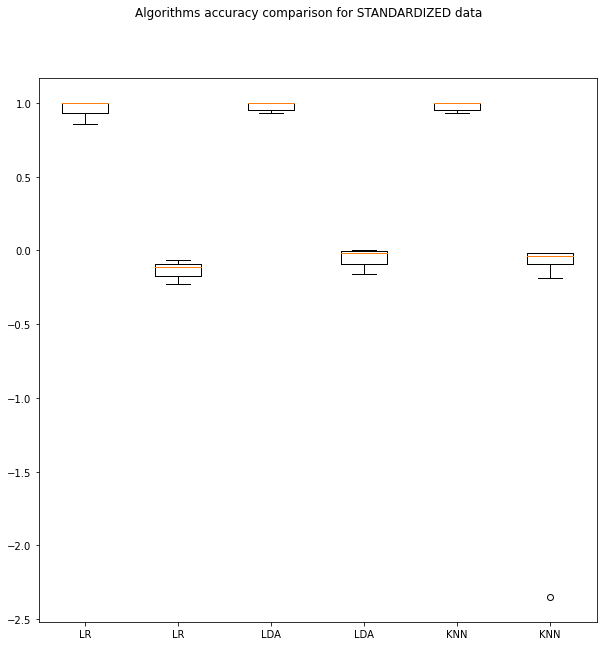


Classification on  NORMALIZED data:

Model:  LR
accuracy : 0.842 (0.133)
neg_log_loss : -0.637 (0.049)

Model:  LDA
accuracy : 0.952 (0.043)
neg_log_loss : -0.104 (0.114)

Model:  KNN
accuracy : 0.966 (0.034)
neg_log_loss : -0.280 (0.685)

Model:  CART
accuracy : 0.945 (0.052)
neg_log_loss : -2.352 (1.829)

Model:  NB
accuracy : 0.972 (0.034)
neg_log_loss : -0.124 (0.154)

Model:  SVM
accuracy : 0.980 (0.031)
neg_log_loss : -0.112 (0.061)



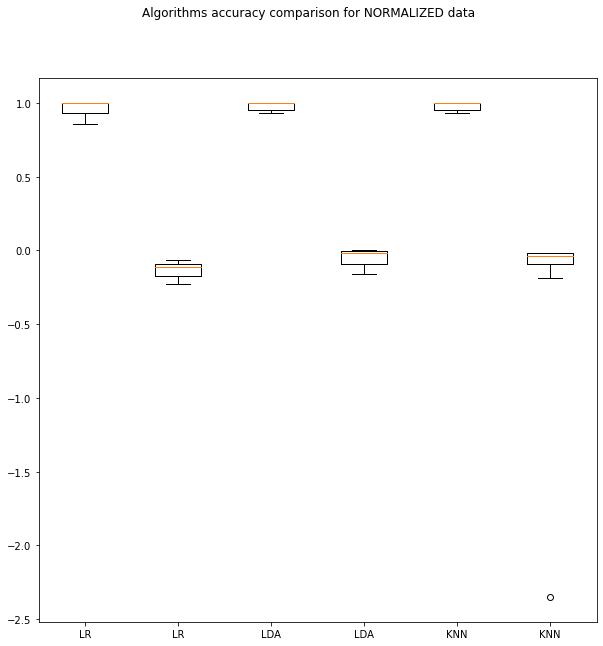

In [24]:
#First the best model will be avaluted using the accuracy and the logarithmic loss
dataset=[]
dataset.append(('NOT PROCESSED', X , Y))
dataset.append(('RESCALED', rescaledX , Y))
dataset.append(('STANDARDIZED', standardizedX , Y))
dataset.append(('NORMALIZED', normalizedX , Y))

models = [] 
models.append(( 'LR'   , LogisticRegression(solver='lbfgs', max_iter=1000)))    
models.append(( 'LDA'  , LinearDiscriminantAnalysis()))
models.append(( 'KNN'  , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'NB'   , GaussianNB()))
models.append(( 'SVM' , SVC(probability=True))) 

metrics=['accuracy','neg_log_loss']

results = []
names = [] 
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

for dat in dataset:
  print('Classification on ',dat[0], 'data:\n')
  for model in models:
    print('Model: ',model[0])
    for metr in metrics:
      cv_results = cross_val_score(model[1], dat[1], dat[2], cv=kfold, scoring=metr)
      results.append(cv_results)
      names.append(model[0])
      print(metr,': %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))
    print()

  #boxplot
  fig = plt.figure()
  fig.suptitle('Algorithms accuracy comparison for %s data'%(dat[0]))
  ax = fig.add_subplot(111)
  plt.boxplot(results[:len(models)])
  ax.set_xticklabels(names)
  plt.show()

  print()

Considering these results the best classification is done on NOT PROCESSED data using LR. In the following steps we use the last parameters on these data.


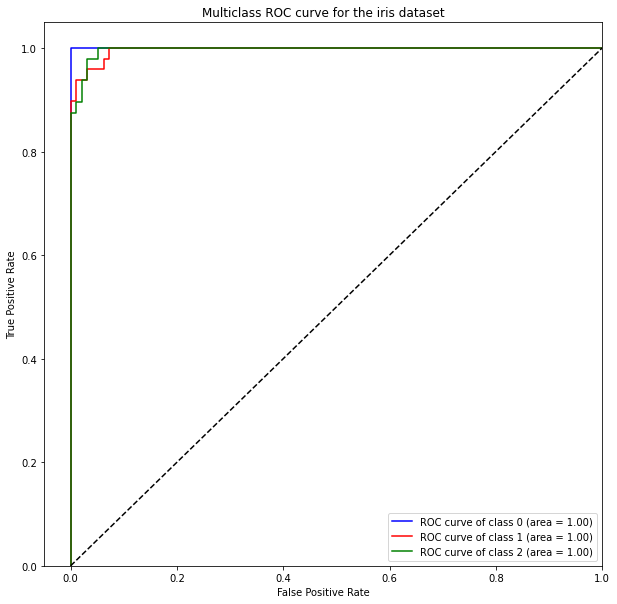

In [25]:
#AREA UNDER THE ROC CURVE 
#In one axis is represented the sensibility (TPR= true positive rate), in the other one the specificity (FPR= false positive rate). 
#The model is reliable if the AUC is close to 1.

Y_classes=[]

for flower in Y:
  if flower=='setosa':
    Y_classes.append(0)
  elif flower=='versicolor':
    Y_classes.append(1)
  else:
    Y_classes.append(2)

Y_classes=np.array(Y_classes)

Y_bin=label_binarize(Y_classes, classes=[0,1,2])
num_classes=3

pipe= Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())])
y_score = cross_val_predict(pipe, X, Y_classes, cv=kfold ,method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve for the iris dataset')
plt.legend(loc="lower right")
plt.show()

[[48  0  0]
 [ 0 46  3]
 [ 0  2 46]]


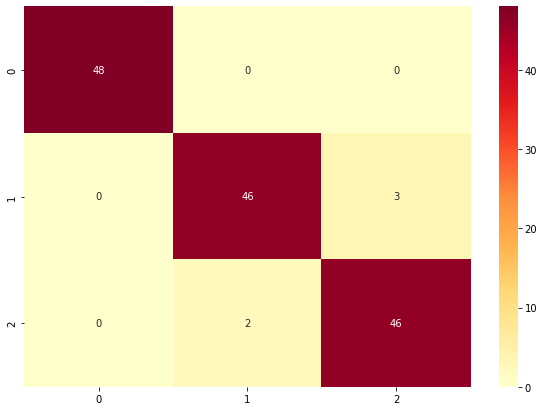

In [26]:
#CONFUSION MATRIX: in this case the matrix is a 3-class confusion matrix 
#The classification is quite accurate if the majority of the predictions fall on the diagonal line of the matrix. Bad predictions are off-diagonal elements. 
#0==setosa, 1==versicolor, 2==virginica 

model=LogisticRegression(solver='lbfgs', max_iter=1000)
predicted = cross_val_predict(model, X, Y, cv=kfold)    
matrix = confusion_matrix(Y, predicted)
print(matrix)

%matplotlib inline
df_cm = pd.DataFrame(matrix)
plt.figure(figsize = (10,7))
sbn.heatmap(df_cm, annot=True, cmap="YlOrRd", fmt="d")

In [27]:
#CLASSIFCATION REPORT: since the dataset resampled with K-fold Cross-Validation method is not divided in training and test sets we need to use
#the dataset that comes from the splitting.
model=LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, Y_train)
pred = model.predict(X_test)
report = classification_report(Y_test, pred)
print(report)
  

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       0.88      0.93      0.90        15
   virginica       0.95      0.90      0.92        20

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48



The different classifcation metrics used to measure the overall performance of the model trained with logistic regression sems to performs a good prediction (the species that is better classified is setosa). 